# Map Nested -> Global at Single Resolution

This is a notebook that documents how we map a nested model (at 2 resolutions) to a single resolution global model.

The critical part of this workflow is to use the `global_mask` attribute in the anemoi dataset.
This mask keeps track of which points on the global grid are kept, and which ones are removed and replaced by the LAM data.

The workflow consists of:
* Defining a mask that is the opposite of the `global_mask` attribute
* Extract the LAM portion of the nested output
* Regrid it to the full global grid target domain, using the mask to define the "unmapped zone"
* "Stack" and concatenate the regridded LAM portion together with the non-LAM portion of the Nested output as 1D vectors
* Reshape to lat/lon

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import xesmf

from eagle.tools.data import open_anemoi_inference_dataset, reshape_cell_to_latlon, reshape_cell_to_xy
from ufs2arco.transforms.horizontal_regrid import get_bounds, maybe_make_dataset_c_contiguous
from anemoi.datasets import open_dataset

In [2]:
lam_index=64220
rename = {"latitude": "lat", "longitude": "lon"}

In [3]:
ds = open_anemoi_inference_dataset(
    "/pscratch/sd/t/timothys/nested-eagle/v0/10percent/csmswt/logoffline-trim10-ll10-win4320/inference/2023-03-08T00.240h.nc",
    model_type="nested-global",
    lam_index=lam_index,
    vars_of_interest=["t2m", "gh"],
    levels=[500],
    load=True,
)
ds = ds.rename(rename)

In [4]:
data_dir = "/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/data"
ads = open_dataset(
    cutout=[
        {"dataset": f"{data_dir}/hrrr.zarr", "trim_edge": [10, 11, 10, 11]},
        f"{data_dir}/gfs.zarr",
    ],
    adjust="all",
    min_distance_km=0,
)
    

Dataset /pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/data/hrrr.zarr has missing dates
Dataset /pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/data/gfs.zarr has missing dates


In [14]:
tds = xr.load_dataset("/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/data/global_one_degree.nc")
gmask = ads.global_mask.reshape((len(tds.lat), len(tds.lon)))
tds["mask"] = xr.DataArray(
    np.where(gmask, 0, 1),
    dims=("lat", "lon"),
)

In [15]:
cds = ds.isel(cell=slice(lam_index, None))

In [16]:
lds = ds.isel(cell=slice(lam_index))
lds = reshape_cell_to_xy(lds, n_x=359-11-10, n_y=211-11-10)
lds = lds.set_coords(["lat", "lon"])
lds = get_bounds(lds)
lds = maybe_make_dataset_c_contiguous(lds)

In [19]:
regridder = xesmf.Regridder(
    ds_in=lds,
    ds_out=tds,
    method="conservative_normed",
    unmapped_to_nan=True,
)

/global/homes/t/timothys/.conda/envs/anemoi/lib/python3.11/site-packages/xesmf/backend.py:41: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not F_CONTIGUOUS. ' 'Will affect performance.')


In [26]:
ngds = regridder(lds)

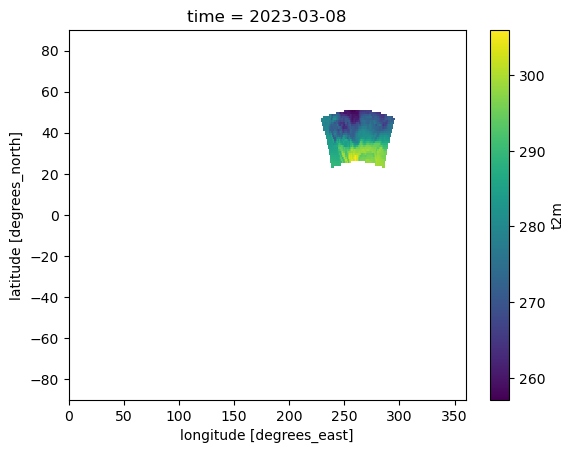

In [27]:
ngds.t2m.isel(time=0).plot()

In [139]:
stacked = ngds.stack(cell2d=("lat", "lon"))
stacked = stacked.swap_dims({"cell2d": "cell"})
stacked = stacked.drop_vars("cell2d")
stacked = stacked.dropna("cell")
stacked

<xarray.Dataset> Size: 1MB
Dimensions:  (time: 41, cell: 1460, level: 1, y_vertices: 191, x_vertices: 339)
Coordinates:
  * time     (time) datetime64[ns] 328B 2023-03-08 ... 2023-03-18
  * level    (level) int64 8B 500
    lat_b    (y_vertices, x_vertices) float32 259kB 22.72 22.75 ... 47.02 46.98
    lon_b    (y_vertices, x_vertices) float32 259kB 238.2 238.4 ... 295.9 296.1
    lat      (cell) float64 12kB 50.5 50.5 50.5 50.5 ... 23.5 23.5 23.5 23.5
    lon      (cell) float64 12kB 250.5 251.5 252.5 253.5 ... 284.5 285.5 286.5
Dimensions without coordinates: cell, y_vertices, x_vertices
Data variables:
    t2m      (time, cell) float32 239kB 261.8 260.7 259.9 ... 297.2 297.1 296.9
    gh       (time, level, cell) float32 239kB 5.369e+03 5.368e+03 ... 5.77e+03
Attributes:
    regrid_method:  conservative_normed

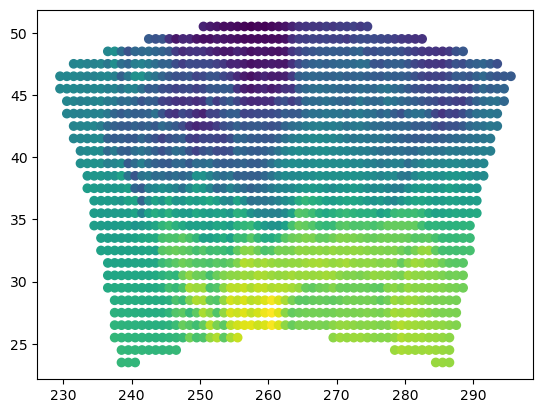

In [140]:
plt.scatter(
    stacked.lon,
    stacked.lat,
    c=stacked.t2m.isel(time=0),
)

In [141]:
stacked.lat.values

array([50.5, 50.5, 50.5, ..., 23.5, 23.5, 23.5], shape=(1460,))

In [142]:
cds.lat.values

array([ 89.5,  89.5,  89.5, ..., -89.5, -89.5, -89.5],
      shape=(63340,), dtype=float32)

In [143]:
cutout_cell = np.arange(len(cds.cell))
lam_cell = len(cutout_cell) + np.arange(len(stacked.cell))
cds["cell"] = xr.DataArray(cutout_cell, coords={"cell": cutout_cell})
stacked["cell"] = xr.DataArray(lam_cell, coords={"cell": lam_cell})

In [144]:
together = xr.concat([cds, stacked], dim="cell")
sort_index = np.lexsort((together.lon, together.lat))
together = together.isel(cell=sort_index)

In [145]:
together = reshape_cell_to_latlon(together.rename({val: key for key, val in rename.items()}))

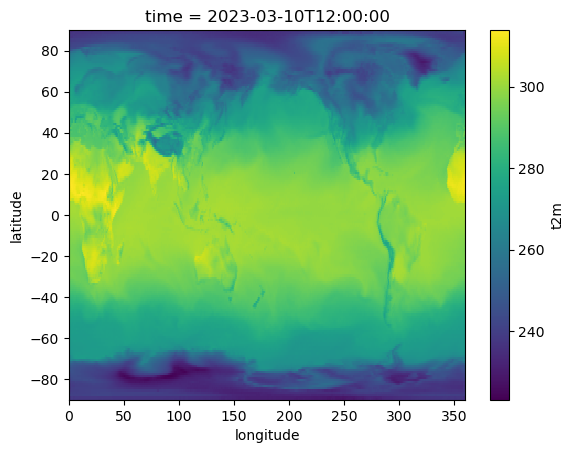

In [146]:
together.t2m.isel(time=10).plot()